In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports Libraries

In [ ]:
from sklearn.model_selection import KFold
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.insert(0, "/content") # to include ../helper_evaluate.py etc.

# From local helper files
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
from helper_train import train_classifier_simple_v2, train_classifier_simple_v2_weighted
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

## Settings and Dataset

In [ ]:
##########################
### SETTINGS
##########################

#Less Complex
RANDOM_SEED = 123           # Reproducibility
BATCH_SIZE = 128             # How many samples to process before updating model parameters
NUM_EPOCHS = 15             # One complete pass through entire dataset
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [ ]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70), interpolation=InterpolationMode.BICUBIC),                                                # Convert into 70x70 pixels
    torchvision.transforms.RandomCrop((64, 64)),                                            # Random cropping to 64x64
    torchvision.transforms.ToTensor(),                                                      # Convert to pytorch tensors
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                    # Normalize pixels

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70), interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [ ]:
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,                                                                  # Number of samples per batch during training
    validation_fraction=0.1,                                                                # Fraction of training data used for validation
    train_transforms=train_transforms,                                                      # Image transformations for training data
    test_transforms=test_transforms,                                                        # Image transformations for testing data
    num_workers=2                                                                           # Number of subprocesses for data loading
)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 170498071/170498071 [00:10<00:00, 15631838.61it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


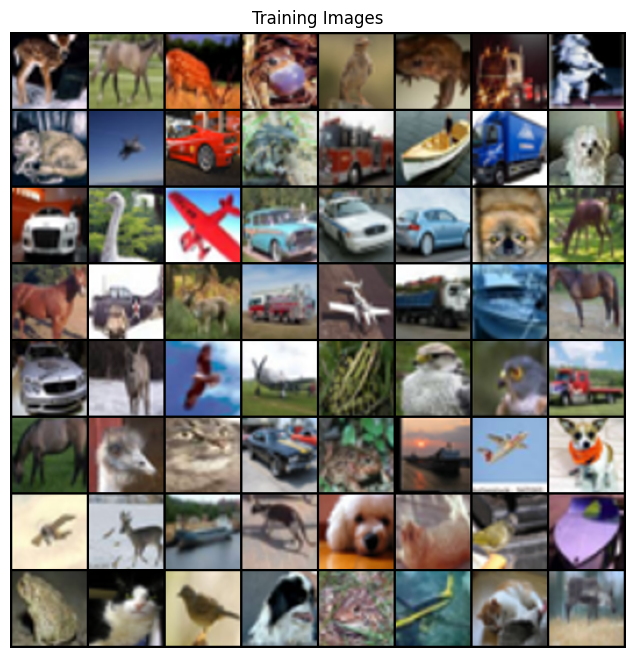

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))

## Modelling

In [ ]:
from torch.utils.data import SubsetRandomSampler, DataLoader
from sklearn.model_selection import KFold
import torch.optim as optim

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)
class_weights = torch.tensor([1.5, 1.0, 1.5, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float)


# Initialize lists to store results
all_minibatch_loss_lists = []
all_train_acc_lists = []
all_valid_acc_lists = []

# Iterate over each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train_loader.dataset)):
    # Create a new instance of MobileNetV2 for each fold
    model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
    model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=10)  # Replace the classifier head
    model = model.to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Added weight_decay as a typical value

    # Create data loaders for the current fold
    train_loader_fold = DataLoader(train_loader.dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
    valid_loader_fold = DataLoader(train_loader.dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(valid_idx))

    # Train the model for this fold
    minibatch_loss_list, train_acc_list, valid_acc_list = train_classifier_simple_v2_weighted(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader_fold,
        valid_loader=valid_loader_fold,
        test_loader=test_loader,
        optimizer=optimizer,
        device=DEVICE,
        class_weights=class_weights,
        best_model_save_path=f'mobilenet-v2-best-{fold_idx + 1}.pt',
        scheduler_on='valid_acc',
        logging_interval=100
    )

    # Store results for this fold
    all_minibatch_loss_lists.append(minibatch_loss_list)
    all_train_acc_lists.append(train_acc_list)
    all_valid_acc_lists.append(valid_acc_list)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/015 | Batch 0000/0313 | Loss: 2.4633
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.6225
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.7257
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.4192
Epoch: 001/015 | Train: 86.76% | Validation: 84.06% | Best Validation (Ep. 001): 84.06%
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.4858
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.4138
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.5213
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.5121
Epoch: 002/015 | Train: 89.05% | Validation: 84.80% | Best Validation (Ep. 002): 84.80%
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.4038
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.2321
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.4782
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.4048
Epoch: 003/015 | Train: 91.52% | Validation: 86.65% | Best Validation (Ep. 003): 86.65%
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.3960
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.2313
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.3775
Epoch: 004/015 |

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy 88.23%


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/015 | Batch 0000/0313 | Loss: 2.5711
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.7680
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.5223
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.3834
Epoch: 001/015 | Train: 85.06% | Validation: 82.74% | Best Validation (Ep. 001): 82.74%
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.4352
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.3325
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.4223
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.4719
Epoch: 002/015 | Train: 89.38% | Validation: 86.03% | Best Validation (Ep. 002): 86.03%
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.4014
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.3465
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.2934
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.4042
Epoch: 003/015 | Train: 87.65% | Validation: 83.75% | Best Validation (Ep. 002): 86.03%
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.3871
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.3384
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.3128
Epoch: 004/015 |

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/015 | Batch 0000/0313 | Loss: 2.6253
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.7036
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.4529
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.5689
Epoch: 001/015 | Train: 86.91% | Validation: 84.11% | Best Validation (Ep. 001): 84.11%
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.4736
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.4412
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.4958
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.4871
Epoch: 002/015 | Train: 87.59% | Validation: 84.26% | Best Validation (Ep. 002): 84.26%
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.2445
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.3829
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.3834
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.3815
Epoch: 003/015 | Train: 90.77% | Validation: 86.18% | Best Validation (Ep. 003): 86.18%
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.3375
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.3175
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.1751
Epoch: 004/015 |

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/015 | Batch 0000/0313 | Loss: 2.5542
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.6563
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.5914
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.5684
Epoch: 001/015 | Train: 86.95% | Validation: 84.29% | Best Validation (Ep. 001): 84.29%
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.3738
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.4409
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.4050
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.2561
Epoch: 002/015 | Train: 86.86% | Validation: 83.02% | Best Validation (Ep. 001): 84.29%
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.3550
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.3961
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.4071
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.3649
Epoch: 003/015 | Train: 89.43% | Validation: 85.28% | Best Validation (Ep. 003): 85.28%
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.3537
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.2360
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.2329
Epoch: 004/015 |

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/015 | Batch 0000/0313 | Loss: 2.4247
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.8786
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.4332
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.3386
Epoch: 001/015 | Train: 85.56% | Validation: 82.45% | Best Validation (Ep. 001): 82.45%
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.4049
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.4712
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.4641
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.3865
Epoch: 002/015 | Train: 88.23% | Validation: 84.85% | Best Validation (Ep. 002): 84.85%
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.3364
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.2585
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.3344
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.3250
Epoch: 003/015 | Train: 90.89% | Validation: 86.21% | Best Validation (Ep. 003): 86.21%
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.2633
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.4059
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.3543
Epoch: 004/015 |

# Identifying Bias and Variance

## Accuracy

In [ ]:
# Initialize empty lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

# Iterate over each fold model
for fold_idx in range(1, k_folds + 1):
    # Load the model checkpoint
    model_path = f'mobilenet-v2-best-{fold_idx}.pt'
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate train accuracy
    train_acc = compute_accuracy(model, train_loader, device=DEVICE)
    print(f'Fold {fold_idx} - Train accuracy: {train_acc:.2f}%')

    # Evaluate test accuracy
    test_acc = compute_accuracy(model, test_loader, device=DEVICE)
    print(f'Fold {fold_idx} - Test accuracy: {test_acc:.2f}%\n\n')

    # Store train and test accuracies
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Convert test accuracies to CPU and then numpy array
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
test_accuracies = [acc.cpu().numpy() for acc in test_accuracies]

# Compute mean, variance, and standard deviation for train accuracies
train_accuracies = np.array(train_accuracies)
train_accuracy_mean = np.mean(train_accuracies)
train_accuracy_variance = np.var(train_accuracies)
train_accuracy_std_dev = np.std(train_accuracies)

# Compute mean, variance, and standard deviation for test accuracies
test_accuracies = np.array(test_accuracies)
test_accuracy_mean = np.mean(test_accuracies)
test_accuracy_variance = np.var(test_accuracies)
test_accuracy_std_dev = np.std(test_accuracies)

print(f'Mean Train Accuracy: {train_accuracy_mean:.2f}%\n')

print(f'Mean Test Accuracy: {test_accuracy_mean:.2f}%\n')
print(f'Test Accuracy Variance: {test_accuracy_variance:.6f}\n')
print(f'Test Accuracy Standard Deviation: {test_accuracy_std_dev:.6f}\n')

# Load the best model for evaluation
best_fold_idx = np.argmax(test_accuracies) + 1
best_model_path = f'mobilenet-v2-best-{best_fold_idx}.pt'
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate the best model on the test data
best_model_test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Best Model Test Accuracy (Fold {best_fold_idx}): {best_model_test_acc:.2f}%')


Fold 1 - Train accuracy: 93.52%
Fold 1 - Test accuracy: 88.14%


Fold 2 - Train accuracy: 94.77%
Fold 2 - Test accuracy: 88.37%


Fold 3 - Train accuracy: 93.50%
Fold 3 - Test accuracy: 88.48%


Fold 4 - Train accuracy: 94.40%
Fold 4 - Test accuracy: 88.75%


Fold 5 - Train accuracy: 95.27%
Fold 5 - Test accuracy: 88.34%


Mean Train Accuracy: 94.30%

Mean Test Accuracy: 88.42%

Test Accuracy Variance: 0.039944

Test Accuracy Standard Deviation: 0.199860

Best Model Test Accuracy (Fold 4): 88.75%


## F1-Score

In [ ]:
import os
import warnings
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set the USE_XLA environment variable before importing JAX
os.environ["USE_XLA"] = "1"

# Now import JAX
import jax

# Initialize empty lists to store train and test F1-scores
train_f1_scores = []
test_f1_scores = []

# Iterate over each fold model
for fold_idx in range(1, k_folds + 1):
    # Load the model checkpoint
    model_path = f'mobilenet-v2-best-{fold_idx}.pt'
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate training F1-score
    train_predictions = []
    train_true_labels = []
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')     # Treat all classes equally because classes are balanced
    print(f'Fold {fold_idx} - Train F1-score: {train_f1:.2f}')

    # Evaluate test F1-score
    test_predictions = []
    test_true_labels = []
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    test_f1 = f1_score(test_true_labels, test_predictions, average='macro')     # Treat all classes equally because classes are balanced
    print(f'Fold {fold_idx} - Test F1-score: {test_f1:.2f}\n\n')

    # Store train and test F1-scores
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

# Convert train and test F1-scores to numpy arrays
train_f1_scores = np.array(train_f1_scores)
test_f1_scores = np.array(test_f1_scores)

# Print out the mean and variance of the train F1-scores
print(f'Mean Train F1-score: {np.mean(train_f1_scores):.2f}\n')

# Print out the mean and variance of the test F1-scores
print(f'Mean Test F1-score: {np.mean(test_f1_scores):.2f}\n')
print(f'Test F1-score Variance: {np.var(test_f1_scores):.6f}\n')
print(f'Test F1-score Standard Deviation: {np.std(test_f1_scores):.6f}')

# Print the index of the best model
best_fold_idx = np.argmax(test_f1_scores) + 1
print(f'Best Model in terms of F1-score: Fold {best_fold_idx}')

Fold 1 - Train F1-score: 0.94
Fold 1 - Test F1-score: 0.88


Fold 2 - Train F1-score: 0.95
Fold 2 - Test F1-score: 0.88


Fold 3 - Train F1-score: 0.94
Fold 3 - Test F1-score: 0.89


Fold 4 - Train F1-score: 0.94
Fold 4 - Test F1-score: 0.89


Fold 5 - Train F1-score: 0.95
Fold 5 - Test F1-score: 0.88


Mean Train F1-score: 0.94

Mean Test F1-score: 0.88

Test F1-score Variance: 0.000003

Test F1-score Standard Deviation: 0.001690
Best Model in terms of F1-score: Fold 4


## Plot Learning Curve

In [ ]:
# Initialize lists to store training loss across epochs for each fold
all_epoch_losses = []

# Iterate over each fold
for minibatch_loss_list in all_minibatch_loss_lists:
    # Compute epoch losses from minibatch losses
    epoch_losses = []
    for i in range(0, len(minibatch_loss_list), len(train_loader)):
        epoch_loss = np.mean(minibatch_loss_list[i:i+len(train_loader)])
        epoch_losses.append(epoch_loss)
    all_epoch_losses.append(epoch_losses)


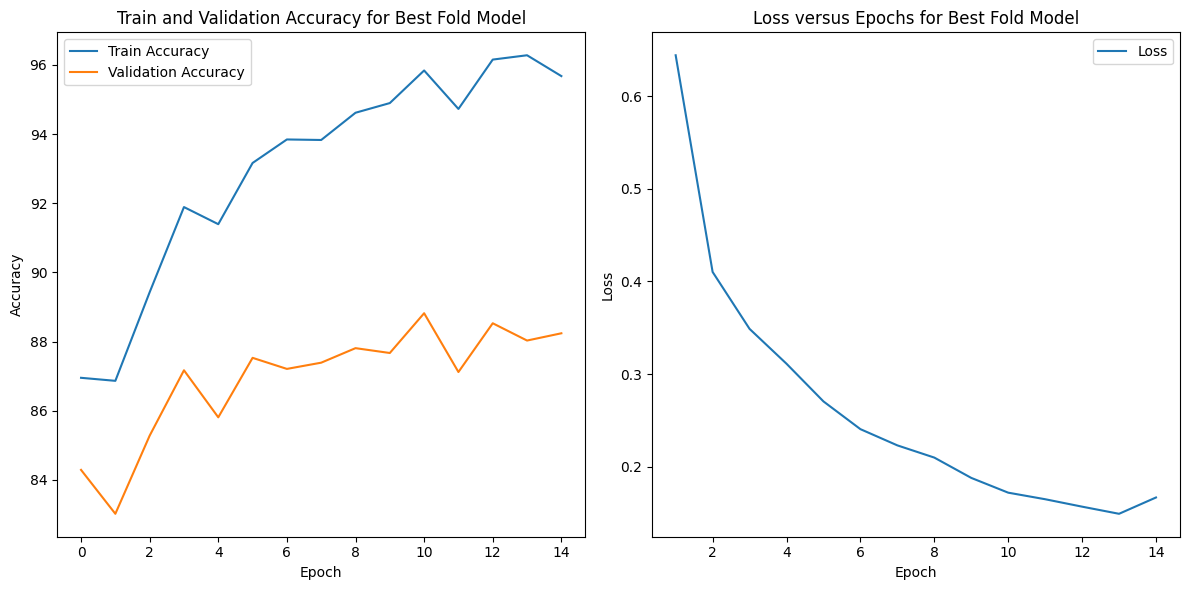

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Get the train and validation accuracy lists for the best fold
best_fold_idx = np.argmax(test_f1_scores)
best_train_acc_list = all_train_acc_lists[best_fold_idx]
best_valid_acc_list = all_valid_acc_lists[best_fold_idx]

# Plot train and validation accuracy
axes[0].plot(best_train_acc_list, label='Train Accuracy')
axes[0].plot(best_valid_acc_list, label='Validation Accuracy')
axes[0].set_title('Train and Validation Accuracy for Best Fold Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Get the epoch loss list for the best fold
best_epoch_loss_list = all_epoch_losses[best_fold_idx]

# Plot loss versus epochs
epochs = range(1, len(best_epoch_loss_list) + 1)
axes[1].plot(epochs, best_epoch_loss_list, label='Loss')
axes[1].set_title('Loss versus Epochs for Best Fold Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Save the Model

In [ ]:
import os
import numpy as np
import pandas as pd

# Define directory to save the metrics
metrics_dir = '/content/drive/MyDrive/tempFolder/1.0/metrics'

# Ensure the directory exists
os.makedirs(metrics_dir, exist_ok=True)

# Save train and test accuracies
np.save(os.path.join(metrics_dir, 'train_accuracies.npy'), np.array(train_accuracies))
np.save(os.path.join(metrics_dir, 'test_accuracies.npy'), np.array(test_accuracies))

# Save train and test F1-scores
np.save(os.path.join(metrics_dir, 'train_f1_scores.npy'), np.array(train_f1_scores))
np.save(os.path.join(metrics_dir, 'test_f1_scores.npy'), np.array(test_f1_scores))

# Save minibatch loss lists, train accuracy lists, and valid accuracy lists as object arrays
np.save(os.path.join(metrics_dir, 'minibatch_loss_lists.npy'), np.array(all_minibatch_loss_lists, dtype=object), allow_pickle=True)
np.save(os.path.join(metrics_dir, 'train_acc_lists.npy'), np.array(all_train_acc_lists, dtype=object), allow_pickle=True)
np.save(os.path.join(metrics_dir, 'valid_acc_lists.npy'), np.array(all_valid_acc_lists, dtype=object), allow_pickle=True)

# Convert lists to pandas DataFrame
train_test_metrics = pd.DataFrame({
    'Fold': range(1, k_folds + 1),
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Train F1-score': train_f1_scores,
    'Test F1-score': test_f1_scores
})

# Save metrics to CSV
train_test_metrics.to_csv(os.path.join(metrics_dir, 'train_test_metrics.csv'), index=False)


In [ ]:
# Save the best model based on test F1-score
best_model_path = f'/content/drive/MyDrive/tempFolder/1.0/1.0 F1-0.xX.pt'
model_path = f'mobilenet-v2-best-3.pt'
best_model_state_dict = torch.load(model_path)
torch.save(best_model_state_dict, best_model_path)
print(f'Best model saved at: {best_model_path}')

Best model saved at: /content/drive/MyDrive/tempFolder/1.0/1.0 F1-0.xX.pt


#Evaluation Section

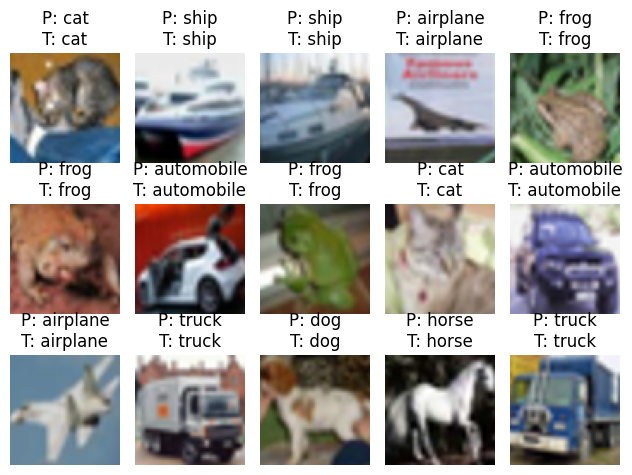

In [ ]:
model.cpu()                                                           # Move model from GPU to CPU, we don't require GPU anymore at this stage.
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))          # Revert normalization process to visualize image data.
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)   # See actual images from the test dataset along the model's predictions. Provides insights into how well model performs on unseen data and which classes it struggles with.

## Confusion Matrix

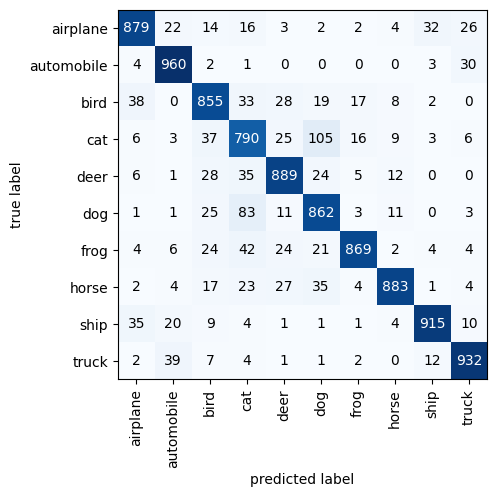

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

## Precision,Recall,F1 Visualization

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the same device as the input tensor
model.to(device)

# Initialize lists to store true and predicted labels
y_true_list = []
y_pred_list = []

# Iterate over the test dataset to obtain true and predicted labels
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass to get predicted labels
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels to the lists
    y_true_list.extend(labels.cpu().numpy())
    y_pred_list.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Define classes and corresponding metrics
classes = list(class_dict.values())
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

<ipython-input-23-9ee15a855d14>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


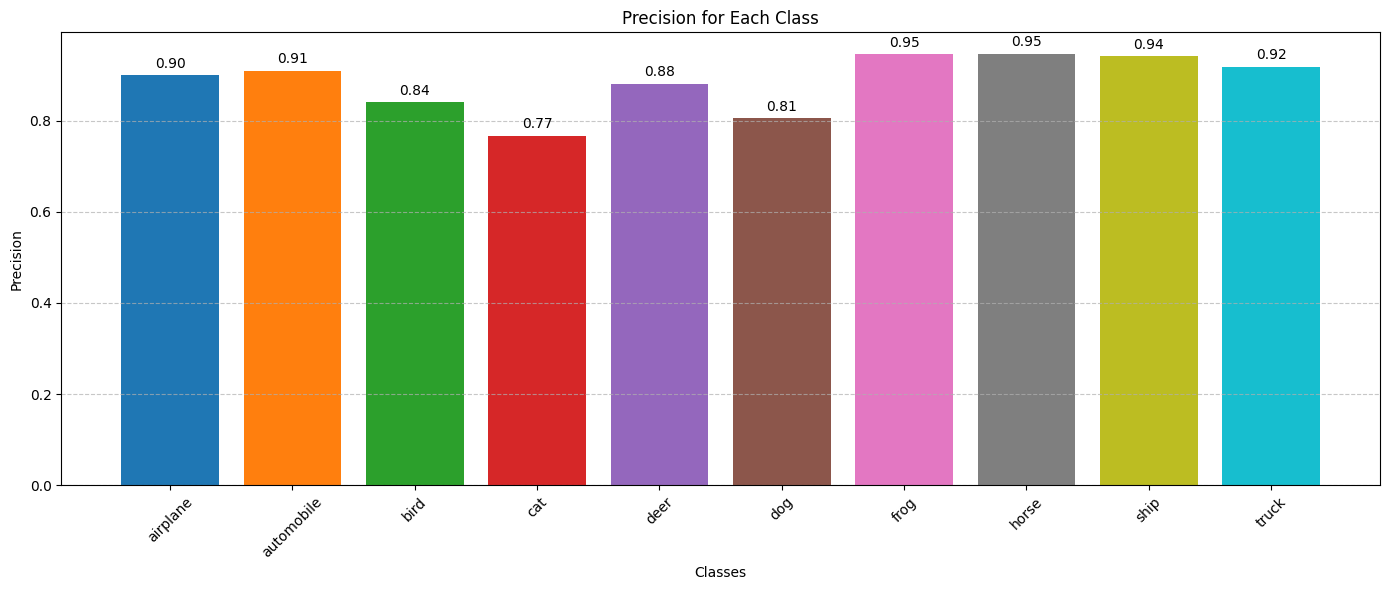

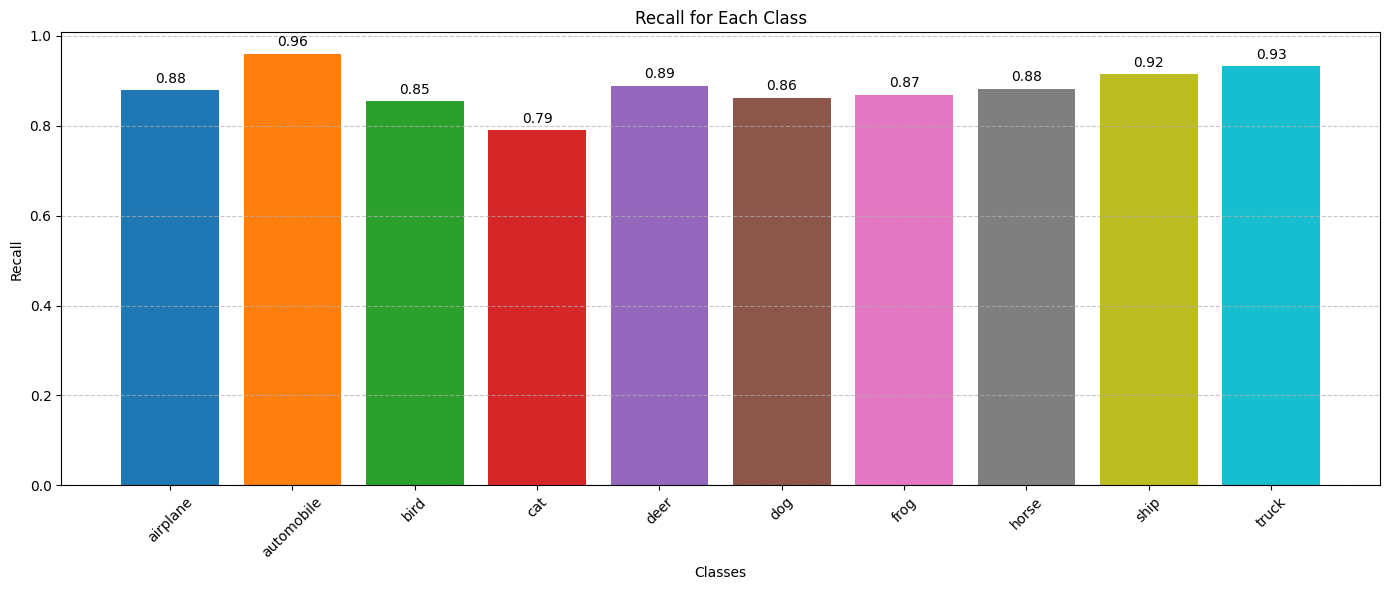

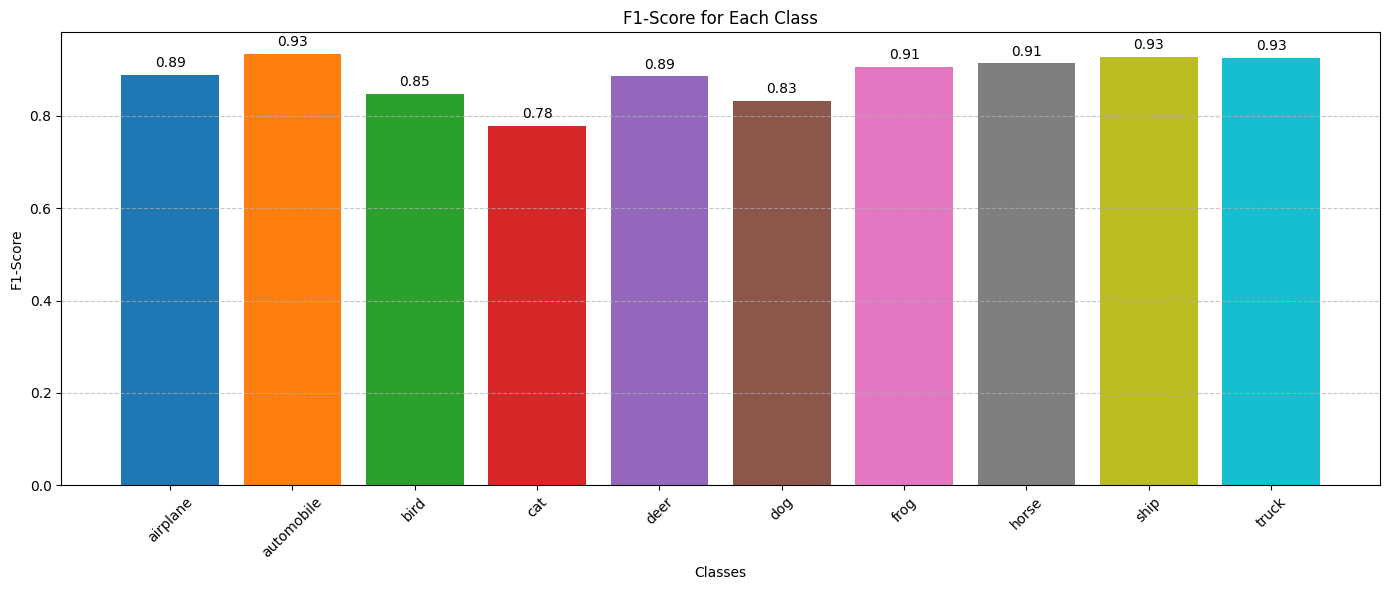

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colormap
colors = plt.cm.get_cmap('tab10', len(classes))

# Plot bar charts for each metric
for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(14, 6))
    bars = plt.bar(classes, metric_values, color=colors(np.arange(len(classes))))
    plt.title(f'{metric_name} for Each Class')
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values to the bars
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # # Add legend
    # legend_labels = [f'{class_name}' for class_name in classes]
    # plt.legend(bars, legend_labels, loc='upper right')

    plt.tight_layout()
    plt.show()
